In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [56]:
train = pd.read_csv('train.csv')

In [57]:
train.head(2)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  

[2 rows x 81 columns]

In [58]:
print(train.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


In [59]:
train = train.drop('Id',axis=1)
train.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  

[2 rows x 80 columns]

In [60]:
train.MSSubClass.describe()

count    1460.000000
mean       56.897260
std        42.300571
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

In [61]:
num = train.select_dtypes(include=['number'])
categ = train.select_dtypes(include=['object'])
numeric_cols = train.select_dtypes(include=['number']).columns
categ_cols = train.select_dtypes(include=['object']).columns

Exploración de los datos

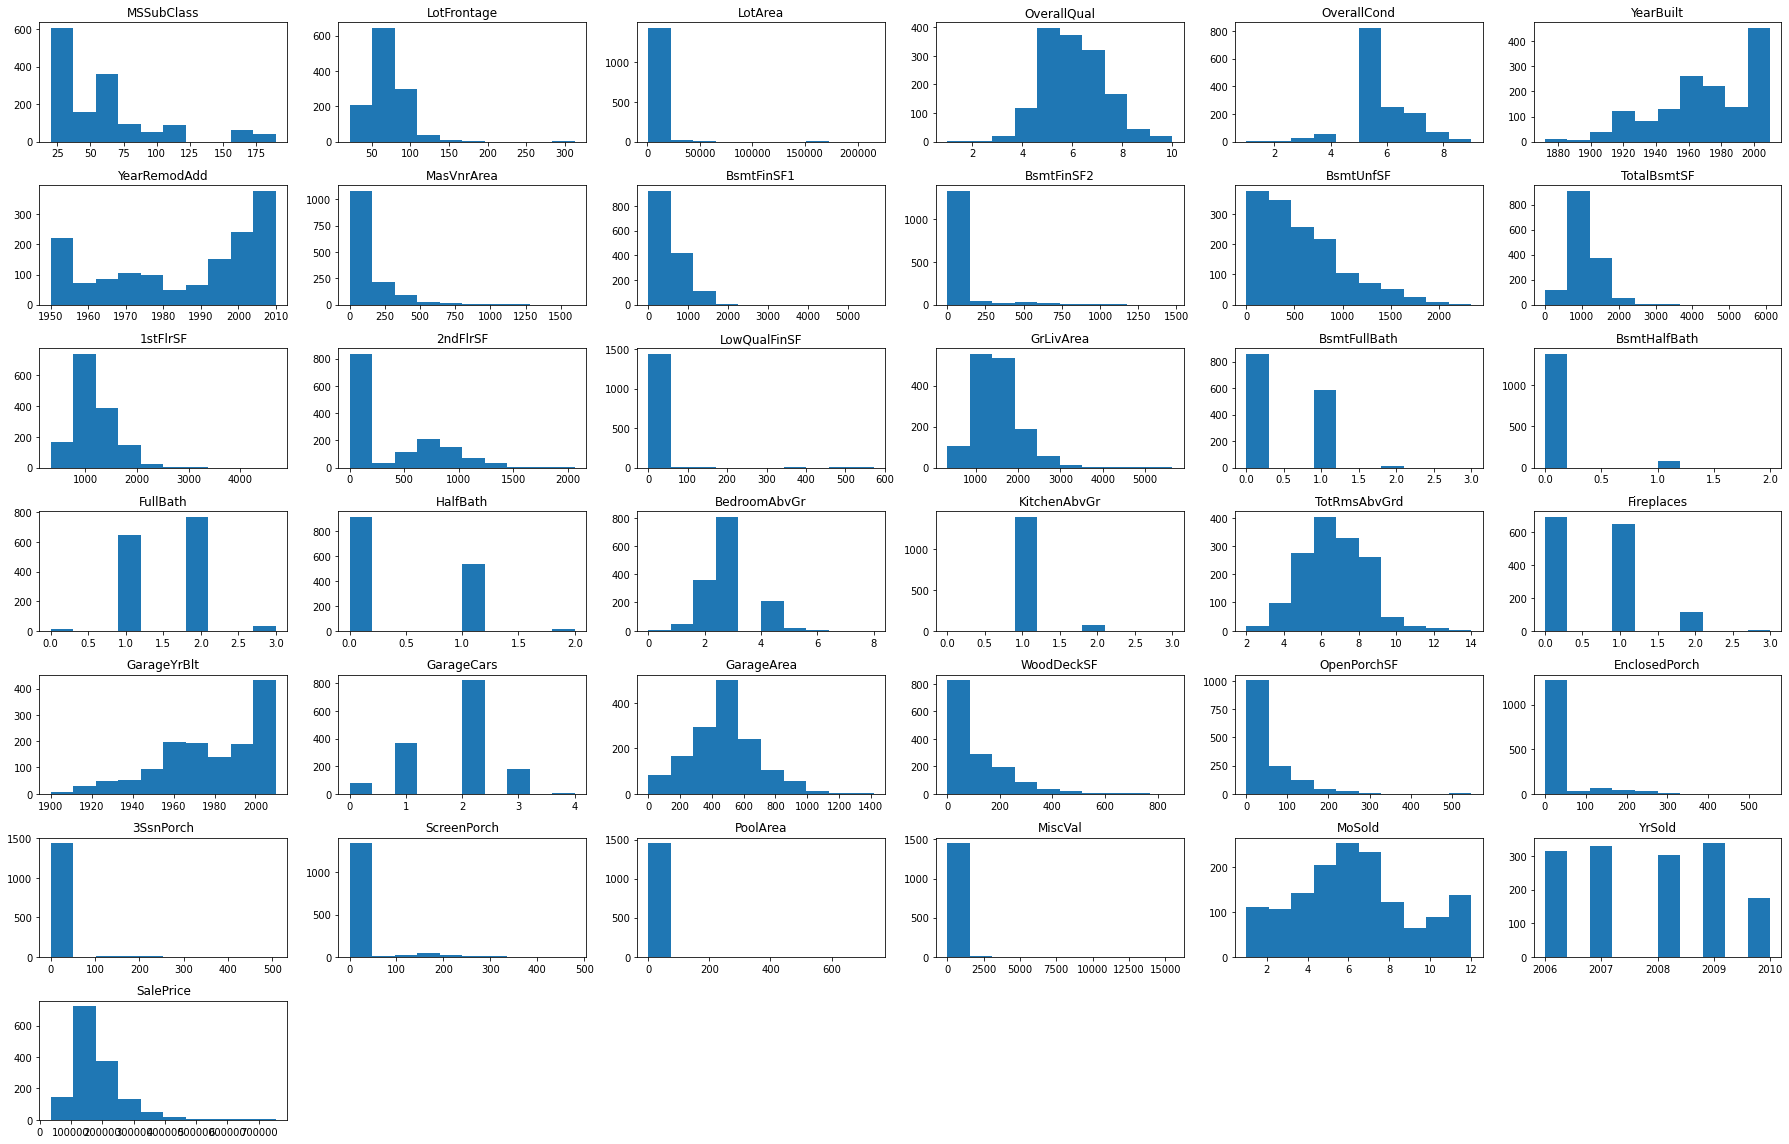

In [62]:
#Distribución de las variables numéricas
num.hist(bins=10, figsize=(25,16),grid=False)
plt.tight_layout()
plt.show()

Columnas con valores faltantes en las columnas numéricas

In [63]:
num.columns[num.isnull().sum() > 0]

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

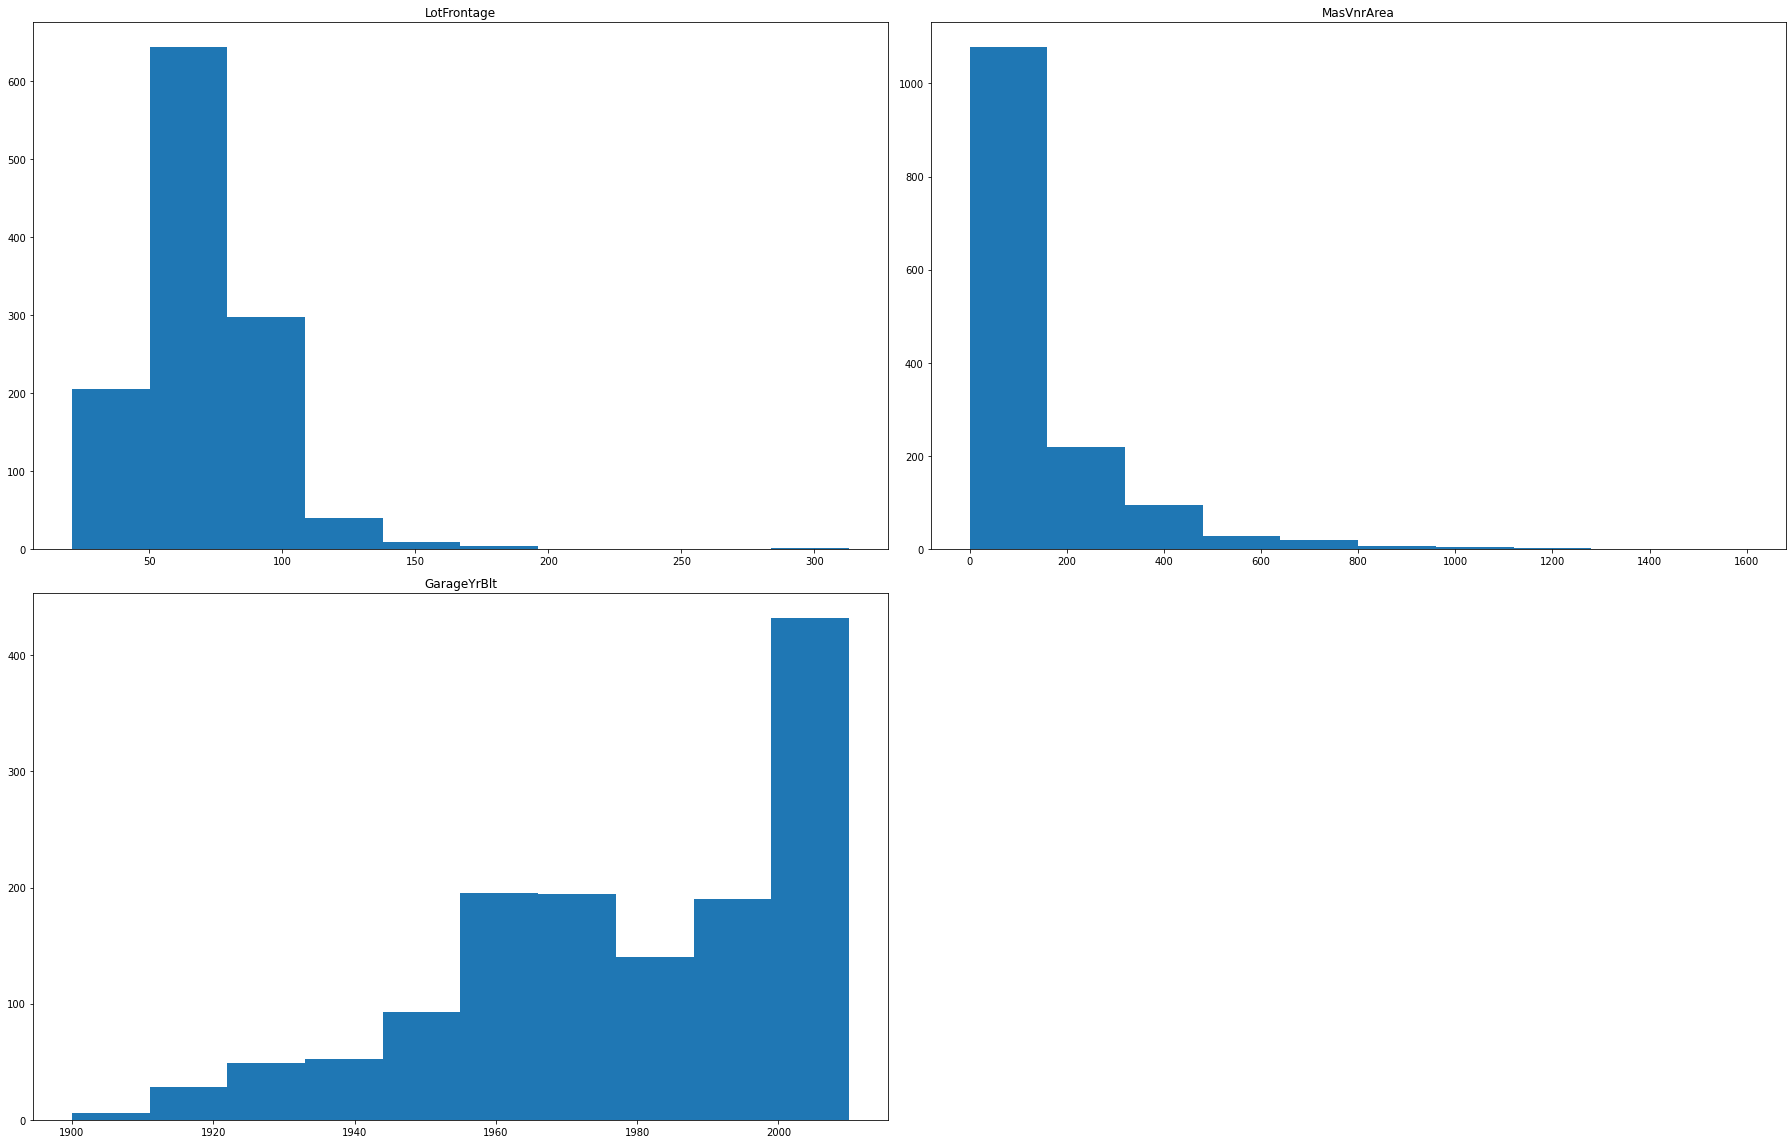

In [64]:
#Columnas numéricas con valores faltantes
num_nulls =num.columns[num.isnull().sum() > 0]
num[num_nulls].hist(bins=10, figsize=(25,16),grid=False)
plt.tight_layout()
plt.show()

Matriz de correlación de las variables númericas

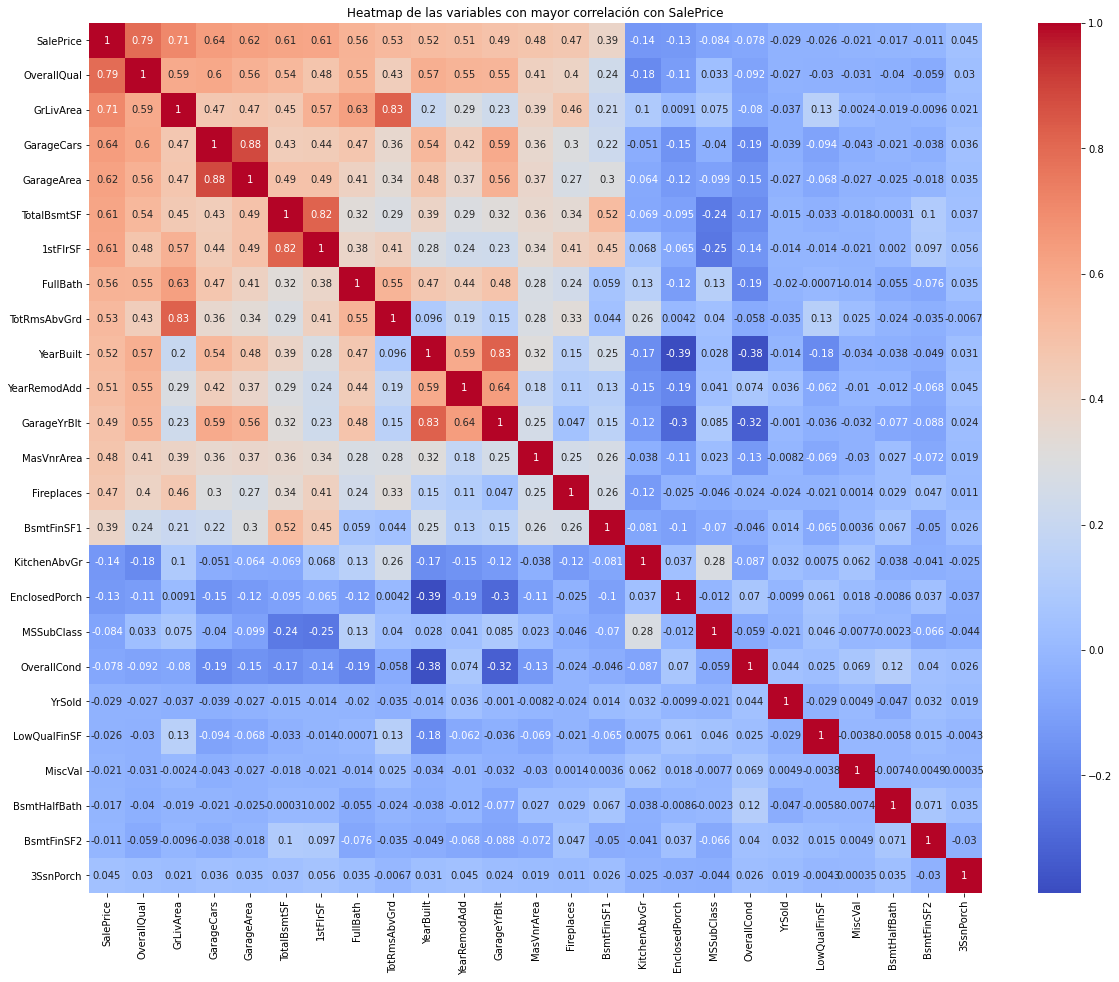

In [65]:
correlation_matrix = num.corr()
top_positive_corr = correlation_matrix['SalePrice'].sort_values(ascending=False).head(15).index
top_negative_corr = correlation_matrix['SalePrice'].sort_values(ascending=True).head(10).index
selected_columns = list(top_positive_corr) + list(top_negative_corr)
selected_data = num[selected_columns]
selected_corr_matrix = selected_data.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(selected_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap de las variables con mayor correlación con SalePrice')
plt.show()

Exploración de las variables categóricas

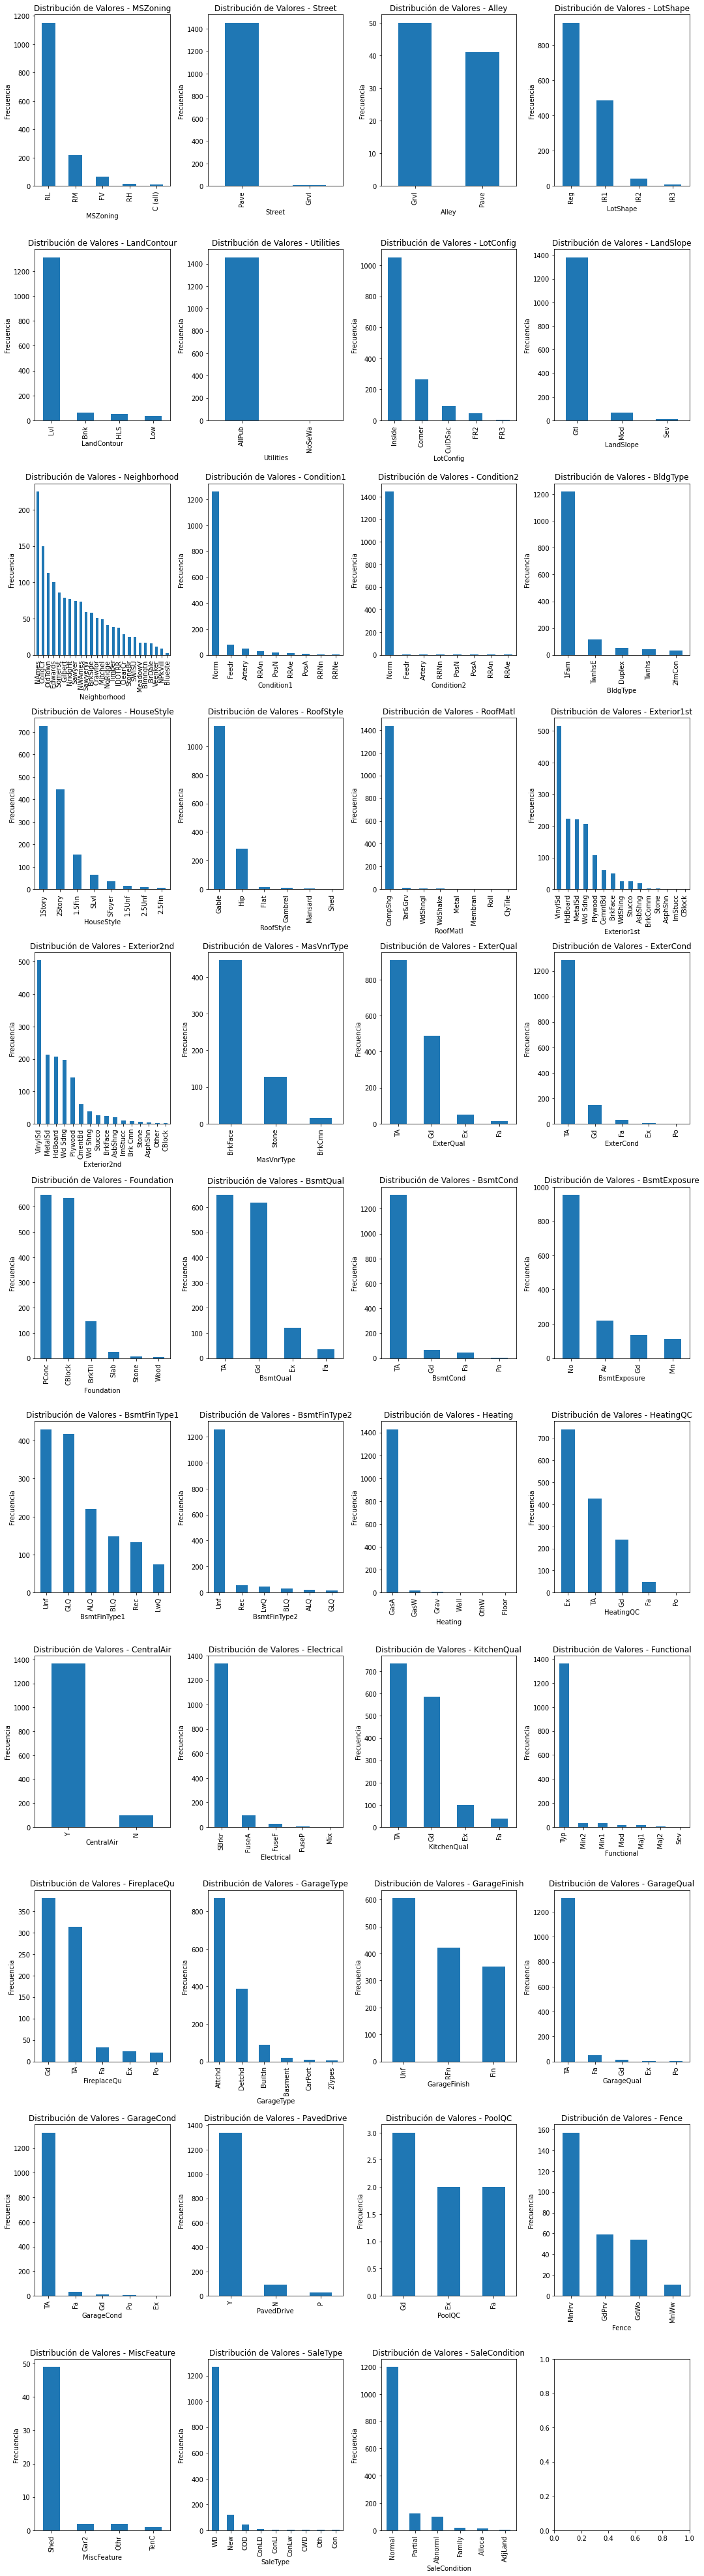

In [66]:
num_plots = len(categ.columns)
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()
for i, column in enumerate(categ.columns):
    ax = axes[i]
    train[column].value_counts().plot(kind='bar', ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Distribución de Valores - {column}')
plt.tight_layout()
plt.show()

Eliminación de valores faltantes

In [67]:
categ_null=categ.isnull().sum().sort_values(ascending=False)
categ[categ_null[categ_null > 0].index].isnull().sum().sort_values(ascending=False)
categ_null = categ_null[categ_null >0]

In [68]:
train[['LotFrontage','MasVnrArea']] = train[['LotFrontage','MasVnrArea']].fillna(0)
train.dropna(subset=['GarageYrBlt'],inplace=True)
train[categ_null.index] = train[categ_null.index].fillna('None')

Backup del df limpio y creación del json para el catálogo de casas

- Cambio de nombre de columnas que empiezan con número por incompatibilidad en la página web

In [69]:
train_clean = train #Backup del df limpio pero sin procesar
no_numbers = {'1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecondFlrSF','3SsnPorch':'ThreeSsnPorch'}
train_clean.rename(columns=no_numbers,inplace=True)
train_cleanjson = train_clean.copy()

In [70]:
print(train_cleanjson.columns)
train_cleanjson.head(2)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive'

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0   None  None        None   
1         Lvl    AllPub       FR2  ...        0   None  None        None   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  

[2 rows x 80 columns]

Creación del json

In [71]:
#Add a column named 'Id' to train_cleanjson as first column
train_cleanjson['id'] = train_cleanjson.index
#Make 'id' the first column
#train_cleanjson = train_cleanjson[['id'] + train_cleanjson.columns.tolist()[1:]]
#Rename columns
#train_cleanjson.rename(columns={'id':'id'}, inplace=True)
#Convert train_cleanjson to json
import json
casas_dict = train_cleanjson.to_dict(orient='records')
casas_json = json.dumps({"casas": casas_dict}, indent=4)
with open('KREND.json', 'w') as archivo:
    archivo.write(casas_json)

In [72]:
train_clean.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   
3          70       RL         60.0     9550   Pave  None      IR1   
4          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0   None  None        None   
1         Lvl    AllPub       FR2  ...        0   None  None        None   
2         Lvl    AllPub    Inside  ...        0   None  None        None   
3         Lvl    AllPub    Corner  ...        0   None  None        None   
4         Lvl    AllPub       FR2  ...        0   None  None        None   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [73]:
train_cleanjson.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   
3          70       RL         60.0     9550   Pave  None      IR1   
4          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig  ... PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    Inside  ...   None  None        None       0   
1         Lvl    AllPub       FR2  ...   None  None        None       0   
2         Lvl    AllPub    Inside  ...   None  None        None       0   
3         Lvl    AllPub    Corner  ...   None  None        None       0   
4         Lvl    AllPub       FR2  ...   None  None        None       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  id  
0      2   2008        WD         Normal     208500   0  
1      5   2007        WD         Normal     181500   1  
2      9   2008        WD         Normal     223500   2  
3      2   2006        WD        Abnorml     140000   3  
4     12   2008        WD         Normal     250000   4  

[5 rows x 81 columns]

Creación del modelo
- División de X (predictores) y Y (target)

In [74]:
X = train_clean.drop('SalePrice',axis=1)
y = train_clean['SalePrice']

- División de columnas numéricas y categóricas para ajustar el preprocesamiento

In [75]:
numeric_cols = train.select_dtypes(include=['number']).columns
categ_cols = train.select_dtypes(include=['object']).columns

Creación del pipeline con el modleo y preprocesamiento
- Se usa ColumnTransformer para el preprocesamiento, pasamos StandarScaler (normalizar datos, les damos media 0 y desviación estándar de 1) para las variables númericas y OneHotEncoder (creación de dummy variables) para las columnas categóricas (con la instrucción de ignorar los valores desconocidos)
- Se usa el modelo de Gradient Boosting Regressor para predecir los precios (se ajustan los hiperparamteros para mejorar su desempeño)
- Se agregan los pasos al pipeline
 

In [76]:
#PREPROCESAMIENTO
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#Escalamiento para las variables numericas
#Dummies para las variables categoricas
preprocessing = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_cols[:-1]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categ_cols)
    ])
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
modelo = GradientBoostingRegressor(criterion= 'squared_error', learning_rate= 0.2,
                                    loss= 'squared_error', n_estimators= 200) 
pipeline = Pipeline(steps=[('preprocessor', preprocessing),
                           ('model', modelo)])

- Se ajusta el modelo

In [77]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'Ha...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model',
                 GradientBoostingRegressor(criterion='squared_error',
                                           learning_rate=0.2,
                                           n_estimators=200))])

Prueba: Leer test, llenar NA y hacer predicciones. Exportar a csv para evaluar el rendimiento del modelo en Kaggle
- En Kaggle, el modelo se evalua usando el Root Mean Squared Error del logaritmo de la variables 'SalePrice' y se sube un .csv con dos columnas 'Id' y 'SalePrice'

In [78]:
version = 1

In [79]:
test = pd.read_csv('test.csv')
test.rename(columns=no_numbers,inplace=True)
X_ = test.drop(['Id'],axis=1)
y_ = test['Id']
media = X_[['YearBuilt', 'YearRemodAdd','GarageYrBlt','YrSold']].mean()
X_[['YearBuilt', 'YearRemodAdd','GarageYrBlt','YrSold']].fillna(media)
X_.fillna(0,inplace=True)
results = pipeline.predict(X_)

csv =pd.DataFrame({'Id':test['Id'], 'SalePrice': results})
csv.to_csv(f'test_results_{version}.csv',index=False)
version += 1

Explorar las columnas incluidas en el modelo entrenado

In [80]:
pipeline.feature_names_in_

array(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
     

Exportar modelo

In [81]:
joblib.dump(pipeline,'pipeline_houses_final.joblib')

['pipeline_houses_final.joblib']